# Global imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Qiskit
from qiskit import BasicAer
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.datasets import ad_hoc_data

# Scikit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores
# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QuantumKernelTraining import QKTKernel
from qksvm.QuantumEmbedding import entangle

seed = 12345

# Qiskit Ad Hoc dataset

In [2]:
np.random.seed(seed=77)
algorithm_globals.random_seed = seed

# generate the dataset
adhoc_dimension = 2
X, y, _, _, adhoc_total = ad_hoc_data(
    training_size=200,
    test_size=2,
    n=adhoc_dimension,
    gap=0.2,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)
y = 2*y-1

print(f"Dataset statistics: {Counter(y)}")

Dataset statistics: Counter({-1: 200, 1: 200})


In [3]:
train_size = 100
test_size = 50
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({-1: 50, 1: 50})
Testing target statistics: Counter({1: 25, -1: 25})


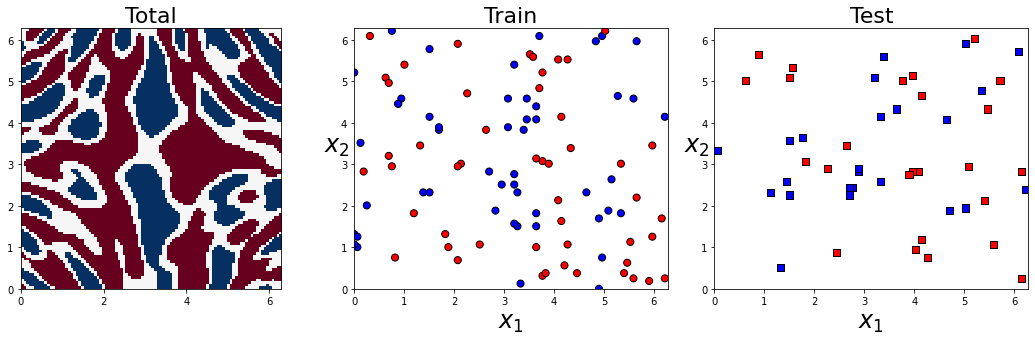

In [4]:
# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# visualize the dataset
xmin = 0; xmax = 2*np.pi
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=22)
ax1.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap=plt.cm.RdBu_r,
    extent=axes,
)

ax2.set_title("Train", fontsize=22)
plot_dataset(X_train, y_train, ax2, axes, marker='o', size=50, stepsize=1.0)
ax2.grid(False)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='s', size=50, stepsize=1.0)
ax3.grid(False)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

## Visualize the classifier

In [5]:
def plot_results(clf, N=20):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap=plt.cm.RdBu_r,
        extent=axes,
    )
    plot_predictions(clf, axs[1], axes, N=N)
    plot_dataset(X_test, y_test, axs[1], axes, marker='s', size=50, stepsize=1.0)
    plot_decisions(clf, axs[2], axes, N=N)
    plot_dataset(X_test, y_test, axs[2], axes, marker='s', size=50, stepsize=1.0)
    plt.tight_layout()
    plt.show()   

# RBF kernel

Best grid search parameters: {'C': 1, 'gamma': 10.0}
Best training score: 0.73

Train set:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test set:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.91
                 MCC:  0.56


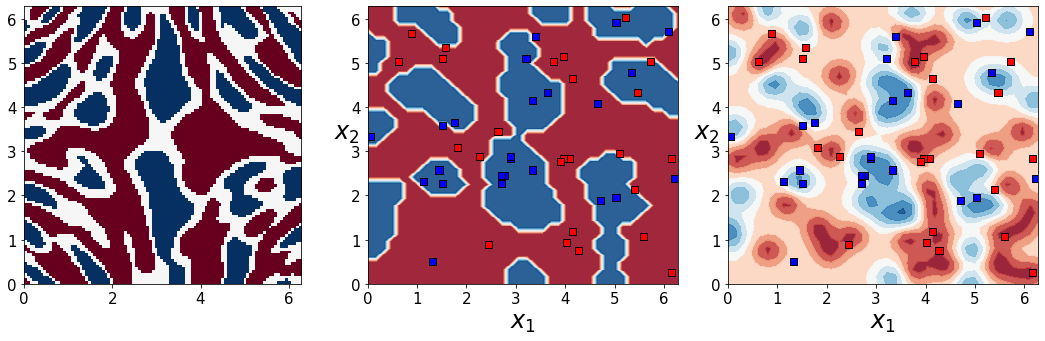

In [6]:
np.random.seed(seed)

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

scores_ = get_scores(clf.best_estimator_, X_train, y_train)
print_scores(scores_, title='Train set:')

scores_ = get_scores(clf.best_estimator_, X_test, y_test)
print_scores(scores_, title='Test set:')

plot_results(clf.best_estimator_, N=40)

In [7]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 8.0, 9.0, 10.0, 11.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

_train_size = 200
_test_size = 50
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=_train_size, test_size=_test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.96

Train set:
   Balanced accuracy:  1.00 +- 0.00
                  F1:  1.00 +- 0.00
             ROC_AUC:  1.00 +- 0.00
                 MCC:  0.99 +- 0.01

Test set:
   Balanced accuracy:  0.87 +- 0.05
                  F1:  0.87 +- 0.05
             ROC_AUC:  0.95 +- 0.03
                 MCC:  0.75 +- 0.11


# QKT SVM

     ┌───┐┌───────────────┐                ┌─────────────────────┐                ┌───┐┌───────────────┐                ┌─────────────────────┐     »
q_0: ┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────┤ Rz(θ[0]*(π - x[0])) ├──■─────────────┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────┤ Rz(θ[0]*(π - x[0])) ├──■──»
     ├───┤├───────────────┤┌─┴─┐           ├─────────────────────┤┌─┴─┐           ├───┤├───────────────┤┌─┴─┐           ├─────────────────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(x[1]*θ[0]) ├┤ X ├──■────────┤ Rz(θ[0]*(π - x[1])) ├┤ X ├──■────────┤ H ├┤ Rz(x[1]*θ[0]) ├┤ X ├──■────────┤ Rz(θ[0]*(π - x[1])) ├┤ X ├»
     ├───┤├───────────────┤└───┘┌─┴─┐      ├─────────────────────┤└───┘┌─┴─┐      ├───┤├───────────────┤└───┘┌─┴─┐      ├─────────────────────┤└───┘»
q_2: ┤ H ├┤ Rz(x[0]*θ[0]) ├─────┤ X ├──■───┤ Rz(θ[0]*(π - x[0])) ├─────┤ X ├──■───┤ H ├┤ Rz(x[0]*θ[0]) ├─────┤ X ├──■───┤ Rz(θ[0]*(π - x[0])) ├─────»
     ├───┤├───────────────┤     └───┘┌─┴─┐ ├─────────────────────┤     └───┘┌─┴─┐ ├───┤├────────────

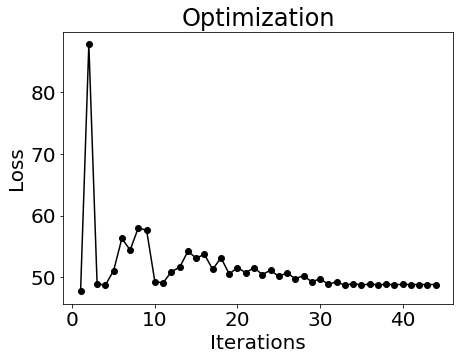


Train set:
   Balanced accuracy:  0.86
                  F1:  0.86
             ROC_AUC:  0.95
                 MCC:  0.72
              precision    recall  f1-score   support

          -1       0.89      0.82      0.85        50
           1       0.83      0.90      0.87        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

Confusion matrix:
[[41  9]
 [ 5 45]]

Test set:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.86
                 MCC:  0.60
              precision    recall  f1-score   support

          -1       0.83      0.76      0.79        25
           1       0.78      0.84      0.81        25

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50

[[19  6]
 [ 4 21]]


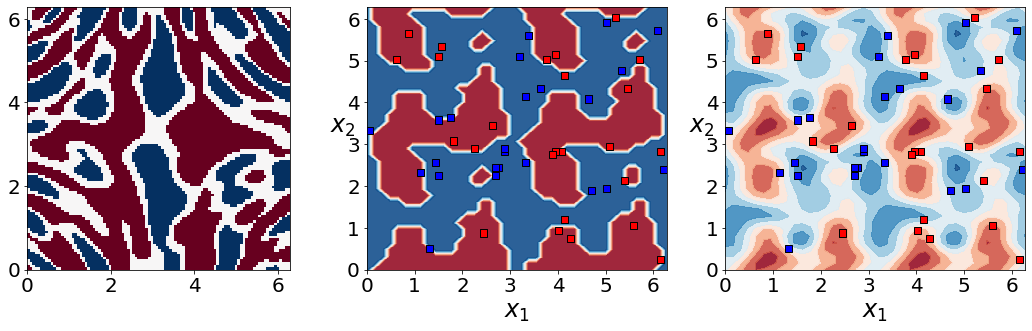

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=4
n_layers=2

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[0]*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='linear')
    for i in range(n_qubits):
        fm.rz(theta[0]*(np.pi-x[j%n_features]), i); j += 1    
    entangle(fm, 'cx', connectivity='linear_r')
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐┌───────────────┐                                    ┌───┐┌───────────────┐
q_0: ┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────────────────────────┤ H ├┤ Rz(x[0]*θ[0]) ├
     ├───┤├───────────────┤┌─┴─┐                               ├───┤├───────────────┤
q_1: ┤ H ├┤ Rz(x[1]*θ[0]) ├┤ X ├──■────────────────────────────┤ H ├┤ Rz(x[1]*θ[0]) ├
     ├───┤├───────────────┤└───┘┌─┴─┐                          ├───┤├───────────────┤
q_2: ┤ H ├┤ Rz(x[0]*θ[0]) ├─────┤ X ├──■───────────────────────┤ H ├┤ Rz(x[0]*θ[0]) ├
     ├───┤├───────────────┤     └───┘┌─┴─┐                     ├───┤├───────────────┤
q_3: ┤ H ├┤ Rz(x[1]*θ[0]) ├──────────┤ X ├──■──────────────────┤ H ├┤ Rz(x[1]*θ[0]) ├
     ├───┤├───────────────┤          └───┘┌─┴─┐                ├───┤├───────────────┤
q_4: ┤ H ├┤ Rz(x[0]*θ[0]) ├───────────────┤ X ├──■─────────────┤ H ├┤ Rz(x[0]*θ[0]) ├
     ├───┤├───────────────┤               └───┘┌─┴─┐           ├───┤├───────────────┤
q_5: ┤ H ├┤ Rz(x[1]*θ[0]) ├────────────────────┤ X ├──

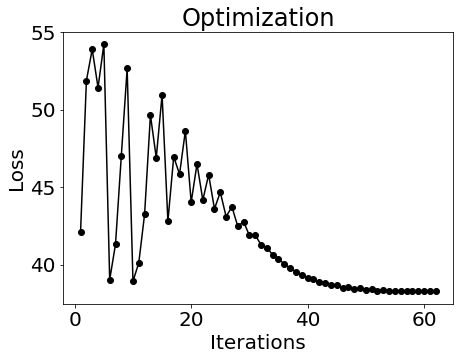


Train set:
   Balanced accuracy:  0.94
                  F1:  0.94
             ROC_AUC:  0.99
                 MCC:  0.88
              precision    recall  f1-score   support

          -1       0.94      0.94      0.94        50
           1       0.94      0.94      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100

Confusion matrix:
[[47  3]
 [ 3 47]]

Test set:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.91
                 MCC:  0.68
              precision    recall  f1-score   support

          -1       0.81      0.88      0.85        25
           1       0.87      0.80      0.83        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50

[[22  3]
 [ 5 20]]


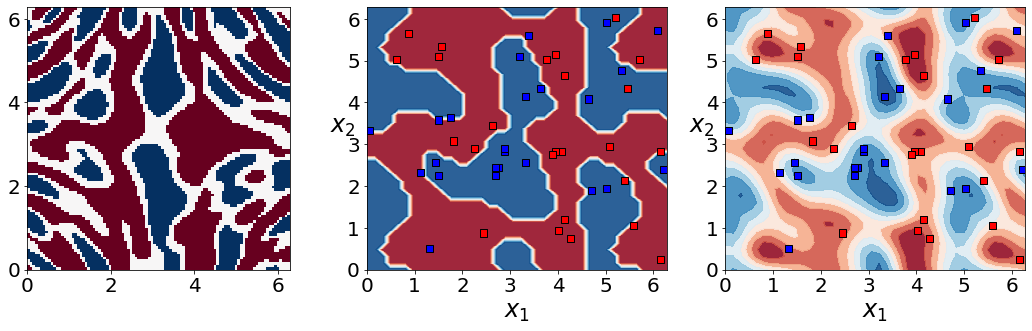

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=1

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[0]*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='linear') 
    # for i in range(n_qubits-2):
    #     fm.ccx(i, (i+2)%n_qubits, (i+1)%n_qubits)
    # fm.barrier()
for i in range(n_qubits):
    fm.h(i)
    fm.rz(theta[0]*x[j%n_features], i); j += 1    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=200,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐┌───────────────┐                                                                                                                        »
q_0: ┤ H ├┤ Rz(x[0]*θ[0]) ├──■────■────■─────────■─────────■──────────────■──────────────■─────────────────────────────────────────────────────────»
     ├───┤├───────────────┤┌─┴─┐  │    │         │         │              │              │                                                         »
q_1: ┤ H ├┤ Rz(x[1]*θ[0]) ├┤ X ├──┼────┼────■────┼────■────┼────■─────────┼────■─────────┼────■──────────────■─────────────────────────────────────»
     ├───┤├───────────────┤└───┘┌─┴─┐  │  ┌─┴─┐  │    │    │    │         │    │         │    │              │                                     »
q_2: ┤ H ├┤ Rz(x[0]*θ[0]) ├─────┤ X ├──┼──┤ X ├──┼────┼────┼────┼────■────┼────┼────■────┼────┼────■─────────┼────■─────────■──────────────────────»
     ├───┤├───────────────┤     └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │    │  ┌─┴─┐  │    │    │    │    │    │      

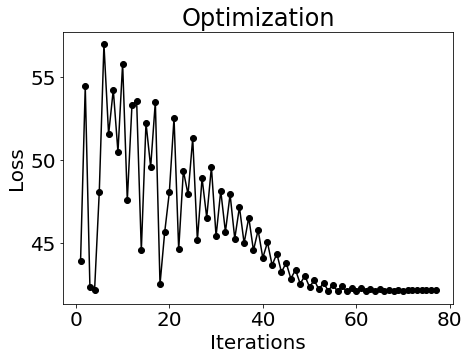


Train set:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.98
                 MCC:  0.90
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95        50
           1       0.96      0.94      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Confusion matrix:
[[48  2]
 [ 3 47]]

Test set:
   Balanced accuracy:  0.86
                  F1:  0.86
             ROC_AUC:  0.90
                 MCC:  0.72
              precision    recall  f1-score   support

          -1       0.85      0.88      0.86        25
           1       0.88      0.84      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50

[[22  3]
 [ 4 21]]


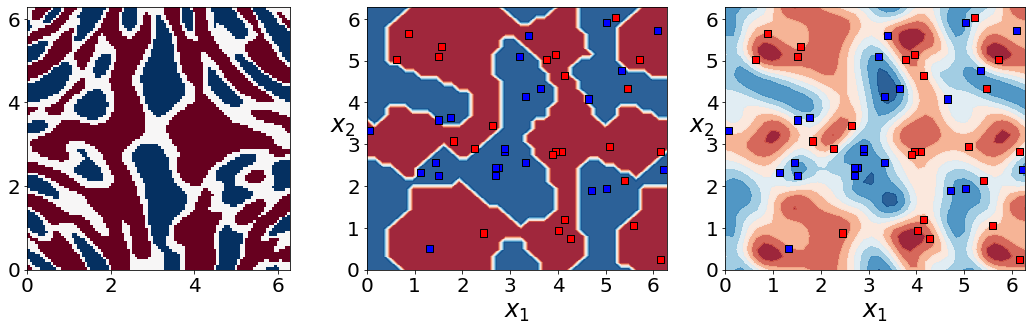

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=1

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[0]*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='full') 
    # for i in range(n_qubits-2):
    #     fm.ccx(i, (i+2)%n_qubits, (i+1)%n_qubits)
    # fm.barrier()
for i in range(n_qubits):
    fm.h(i)
    fm.rz(theta[0]*x[j%n_features], i); j += 1    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=200,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐┌───────────────┐                                    ┌───┐┌───────────────┐                                     
q_0: ┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────────────────────────┤ H ├┤ Rz(x[0]*θ[8]) ├───■─────────────────────────────────
     ├───┤├───────────────┤┌─┴─┐                               ├───┤├───────────────┤ ┌─┴─┐                               
q_1: ┤ H ├┤ Rz(x[1]*θ[1]) ├┤ X ├──■────────────────────────────┤ H ├┤ Rz(x[1]*θ[9]) ├─┤ X ├──■────────────────────────────
     ├───┤├───────────────┤└───┘┌─┴─┐                          ├───┤├───────────────┴┐└───┘┌─┴─┐                          
q_2: ┤ H ├┤ Rz(x[0]*θ[2]) ├─────┤ X ├──■───────────────────────┤ H ├┤ Rz(x[0]*θ[10]) ├─────┤ X ├──■───────────────────────
     ├───┤├───────────────┤     └───┘┌─┴─┐                     ├───┤├────────────────┤     └───┘┌─┴─┐                     
q_3: ┤ H ├┤ Rz(x[1]*θ[3]) ├──────────┤ X ├──■──────────────────┤ H ├┤ Rz(x[1]*θ[11]) ├──────────┤ X ├──■──────────────────
     ├───┤├─────

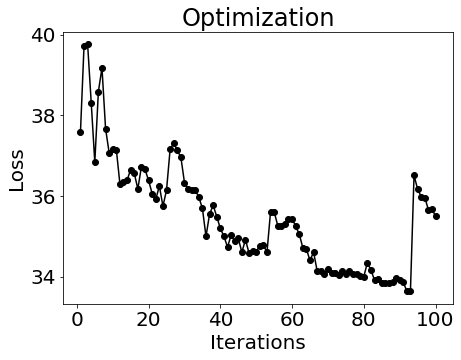


Train set:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98
              precision    recall  f1-score   support

          -1       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion matrix:
[[49  1]
 [ 0 50]]

Test set:
   Balanced accuracy:  0.74
                  F1:  0.74
             ROC_AUC:  0.90
                 MCC:  0.48
              precision    recall  f1-score   support

          -1       0.73      0.76      0.75        25
           1       0.75      0.72      0.73        25

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50

[[19  6]
 [ 7 18]]


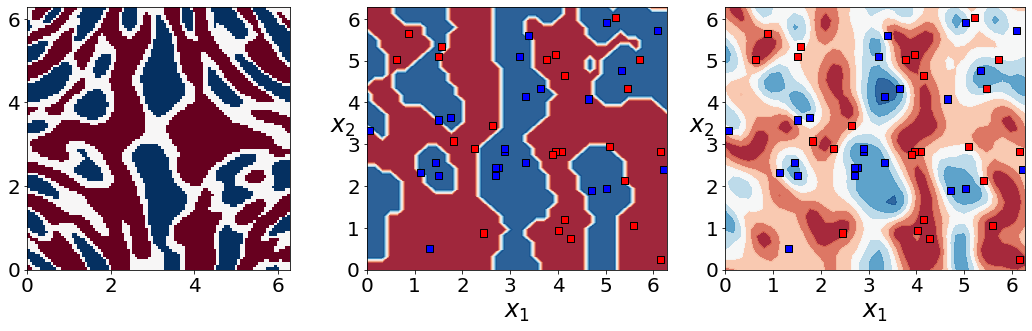

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=2

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[j]*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='linear') 
    # for i in range(n_qubits):
    #     fm.crz(theta[j]*x[j%n_features], i, (i+1)%n_qubits); j += 1
    # fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐┌───────────────┐                                    ┌───┐┌───────────────┐                                    ┌───┐┌───────────────┐     »
q_0: ┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────────────────────────┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────────────────────────┤ H ├┤ Rz(x[0]*θ[0]) ├──■──»
     ├───┤├───────────────┤┌─┴─┐                               ├───┤├───────────────┤┌─┴─┐                               ├───┤├───────────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(x[1]*θ[1]) ├┤ X ├──■────────────────────────────┤ H ├┤ Rz(x[1]*θ[1]) ├┤ X ├──■────────────────────────────┤ H ├┤ Rz(x[1]*θ[1]) ├┤ X ├»
     ├───┤├───────────────┤└───┘┌─┴─┐                          ├───┤├───────────────┤└───┘┌─┴─┐                          ├───┤├───────────────┤└───┘»
q_2: ┤ H ├┤ Rz(x[0]*θ[2]) ├─────┤ X ├──■───────────────────────┤ H ├┤ Rz(x[0]*θ[2]) ├─────┤ X ├──■───────────────────────┤ H ├┤ Rz(x[0]*θ[2]) ├─────»
     ├───┤├───────────────┤     └───┘┌─┴─┐                     ├───┤├───────────────┤     └───┘┌─┴─┐

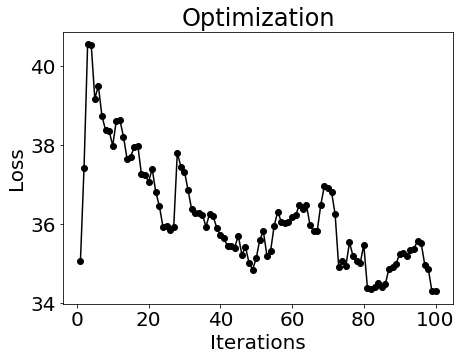


Train set:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98
              precision    recall  f1-score   support

          -1       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion matrix:
[[49  1]
 [ 0 50]]

Test set:
   Balanced accuracy:  0.80
                  F1:  0.79
             ROC_AUC:  0.90
                 MCC:  0.63
              precision    recall  f1-score   support

          -1       0.73      0.96      0.83        25
           1       0.94      0.64      0.76        25

    accuracy                           0.80        50
   macro avg       0.83      0.80      0.79        50
weighted avg       0.83      0.80      0.79        50

[[24  1]
 [ 9 16]]


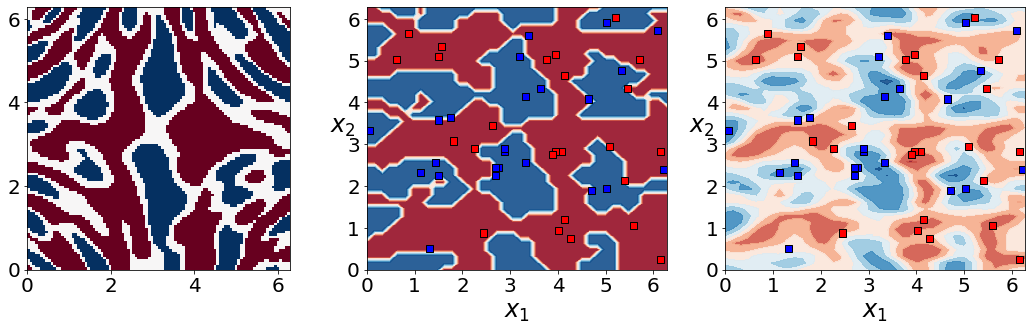

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=4

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[j%n_qubits]*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='linear') 
    # for i in range(n_qubits):
    #     fm.crz(theta[j]*x[j%n_features], i, (i+1)%n_qubits); j += 1
    # fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐┌──────────────────────┐                                    ┌───┐┌───────────────────────┐                                    
q_0: ┤ H ├┤ Rz(x[0]*θ[0] + θ[2]) ├──■─────────────────────────────────┤ H ├┤ Rz(x[0]*θ[0] + θ[10]) ├──■─────────────────────────────────
     ├───┤├──────────────────────┤┌─┴─┐                               ├───┤├───────────────────────┤┌─┴─┐                               
q_1: ┤ H ├┤ Rz(x[1]*θ[1] + θ[3]) ├┤ X ├──■────────────────────────────┤ H ├┤ Rz(x[1]*θ[1] + θ[11]) ├┤ X ├──■────────────────────────────
     ├───┤├──────────────────────┤└───┘┌─┴─┐                          ├───┤├───────────────────────┤└───┘┌─┴─┐                          
q_2: ┤ H ├┤ Rz(x[0]*θ[0] + θ[4]) ├─────┤ X ├──■───────────────────────┤ H ├┤ Rz(x[0]*θ[0] + θ[12]) ├─────┤ X ├──■───────────────────────
     ├───┤├──────────────────────┤     └───┘┌─┴─┐                     ├───┤├───────────────────────┤     └───┘┌─┴─┐                     
q_3: ┤ H ├┤ Rz(x[1]*θ[1] + θ[5]) ├───────

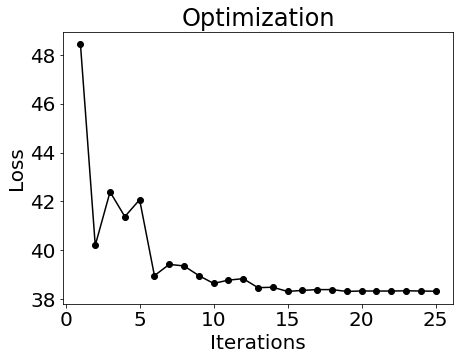


Train set:
   Balanced accuracy:  0.91
                  F1:  0.91
             ROC_AUC:  0.97
                 MCC:  0.82
              precision    recall  f1-score   support

          -1       0.92      0.90      0.91        50
           1       0.90      0.92      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Confusion matrix:
[[45  5]
 [ 4 46]]

Test set:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.86
                 MCC:  0.57
              precision    recall  f1-score   support

          -1       0.73      0.88      0.80        25
           1       0.85      0.68      0.76        25

    accuracy                           0.78        50
   macro avg       0.79      0.78      0.78        50
weighted avg       0.79      0.78      0.78        50

[[22  3]
 [ 8 17]]


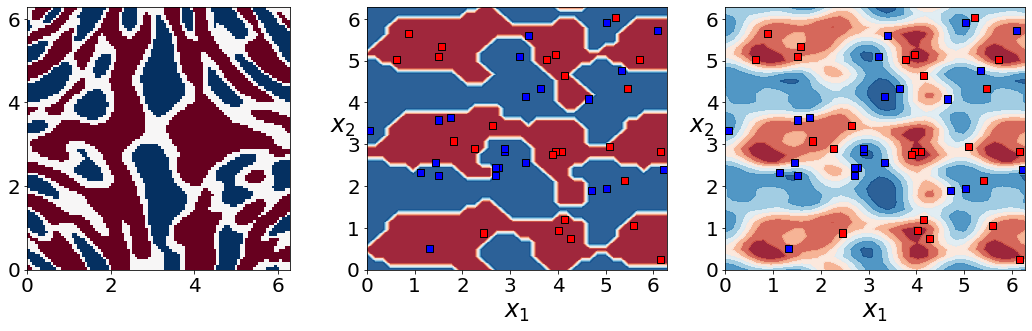

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=2

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=n_features+n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
p = n_features
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[j%n_features]*x[j%n_features]+theta[p], i); j += 1; p += 1
    entangle(fm, 'cx', connectivity='linear') 
    # for i in range(n_qubits):
    #     fm.crz(theta[j]*x[j%n_features], i, (i+1)%n_qubits); j += 1
    # fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
# init_params = 2.0*np.ones(len(fm.train_params))
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[:n_features] = 2.0*np.ones(n_features)

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐     ┌─────────────────────┐                      ┌───┐     ┌─────────────────────┐                      
q_0: ┤ H ├─────┤ Rz(2.0*x[0] + θ[0]) ├───────■──────────────┤ H ├─────┤ Rz(2.0*x[0] + θ[0]) ├───────■──────────────
     ├───┤     ├─────────────────────┤     ┌─┴─┐            ├───┤     ├─────────────────────┤     ┌─┴─┐            
q_1: ┤ H ├─────┤ Rz(2.0*x[1] + θ[0]) ├─────┤ X ├──■─────────┤ H ├─────┤ Rz(2.0*x[1] + θ[0]) ├─────┤ X ├──■─────────
     ├───┤┌────┴─────────────────────┴────┐└───┘┌─┴─┐       ├───┤┌────┴─────────────────────┴────┐└───┘┌─┴─┐       
q_2: ┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├─────┤ X ├──■────┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├─────┤ X ├──■────
     ├───┤├───────────────────────────────┤     └───┘┌─┴─┐  ├───┤├───────────────────────────────┤     └───┘┌─┴─┐  
q_3: ┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├──────────┤ X ├──┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├──────────┤ X ├──
     └───┘└───────────────────────────────┘          └───┘  └───┘└──────

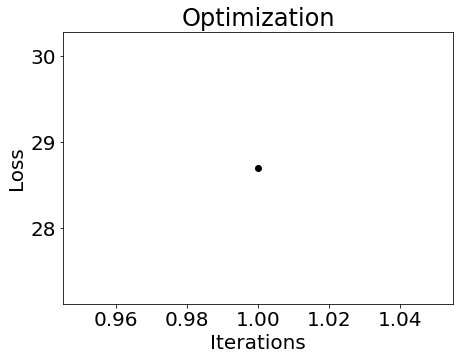


Train set:
   Balanced accuracy:  0.98
                  F1:  0.98
             ROC_AUC:  1.00
                 MCC:  0.96
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98        50
           1       1.00      0.96      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Confusion matrix:
[[50  0]
 [ 2 48]]

Test set:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.90
                 MCC:  0.68
              precision    recall  f1-score   support

          -1       0.81      0.88      0.85        25
           1       0.87      0.80      0.83        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50

[[22  3]
 [ 5 20]]


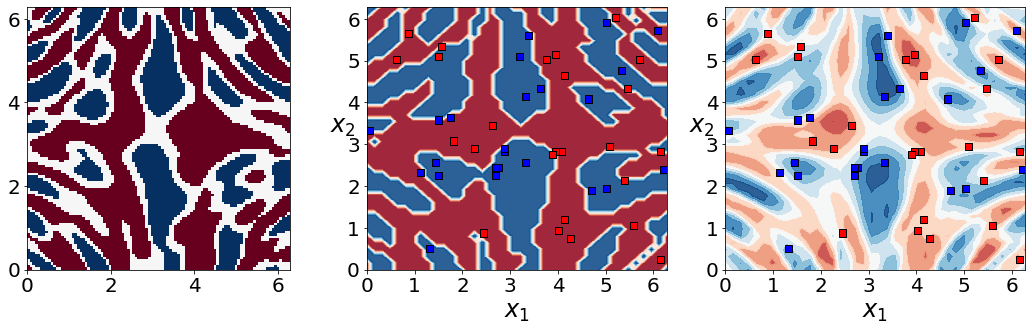

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=4
n_layers=2

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    for i in range(2):
        fm.h(i)
        fm.rz(2.0*x[j%n_features]+theta[0], i); j += 1
    # entangle(fm, 'cx', n_qubits, connectivity='linear') 
    for i in range(2,n_qubits):
        fm.h(i)
        fm.rz(2.0*(np.pi-x[j%n_features])*(np.pi-x[(j+1)%n_features]), i); j += 1
    # for i in range(n_qubits):
    #     fm.crz(theta[1]*x[j%n_features]*x[(j+1)%n_features], i, (i+1)%n_qubits); j += 1
    entangle(fm, 'cx', connectivity='linear') 
    fm.barrier()
# for i in range(fm.num_qubits):
#     fm.ry(fm.encod_params[i%fm.num_features], i) 
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=1,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌──────────────┐                                    ┌──────────┐ ┌──────────┐ ┌──────────────┐                                    ┌───────────┐»
q_0: ┤ Ry(2.0*x[0]) ├──■─────────────────────────────────┤ Rz(θ[0]) ├─┤ Rx(θ[8]) ├─┤ Ry(2.0*x[0]) ├──■─────────────────────────────────┤ Rz(θ[16]) ├»
     ├──────────────┤┌─┴─┐                               ├──────────┤ ├──────────┤ ├──────────────┤┌─┴─┐                               ├───────────┤»
q_1: ┤ Ry(2.0*x[1]) ├┤ X ├──■────────────────────────────┤ Rz(θ[1]) ├─┤ Rx(θ[9]) ├─┤ Ry(2.0*x[1]) ├┤ X ├──■────────────────────────────┤ Rz(θ[17]) ├»
     ├──────────────┤└───┘┌─┴─┐                          ├──────────┤┌┴──────────┤ ├──────────────┤└───┘┌─┴─┐                          ├───────────┤»
q_2: ┤ Ry(2.0*x[0]) ├─────┤ X ├──■───────────────────────┤ Rz(θ[2]) ├┤ Rx(θ[10]) ├─┤ Ry(2.0*x[0]) ├─────┤ X ├──■───────────────────────┤ Rz(θ[18]) ├»
     ├──────────────┤     └───┘┌─┴─┐                     ├──────────┤├───────────┤ ├──────────────┤ 

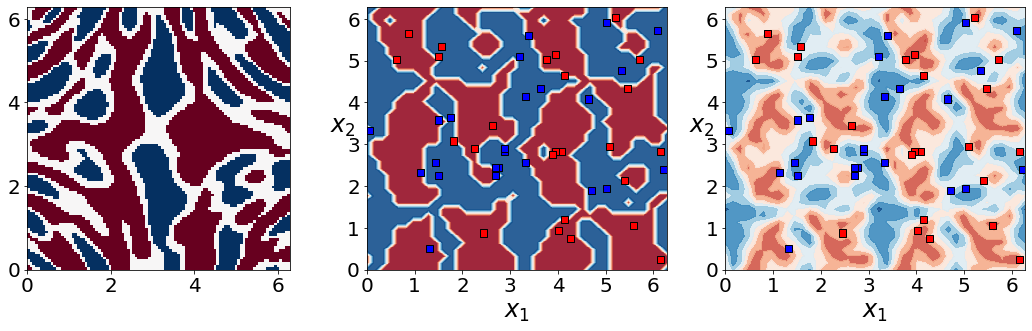

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=5

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=2*n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
p = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(2.0*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='linear') 
    for i in range(n_qubits):
        fm.rz(theta[p], i); p += 1
    for i in range(n_qubits):
        fm.rx(theta[p], i); p += 1
    fm.barrier()
for i in range(n_qubits):
    fm.ry(2.0*x[j%n_features], i); j += 1    

print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐┌───────────────┐                                     ┌───────────────────┐   ┌───┐┌───────────────┐                                    »
q_0: ┤ H ├┤ Rz(x[0]*θ[0]) ├──■──────────────────────────────────┤ U(θ[1],θ[2],θ[3]) ├───┤ H ├┤ Rz(x[0]*θ[0]) ├──■─────────────────────────────────»
     ├───┤├───────────────┤┌─┴─┐                                ├───────────────────┤   ├───┤├───────────────┤┌─┴─┐                               »
q_1: ┤ H ├┤ Rz(x[1]*θ[0]) ├┤ X ├──■─────────────────────────────┤ U(θ[4],θ[5],θ[6]) ├───┤ H ├┤ Rz(x[1]*θ[0]) ├┤ X ├──■────────────────────────────»
     ├───┤├───────────────┤└───┘┌─┴─┐                           ├───────────────────┤   ├───┤├───────────────┤└───┘┌─┴─┐                          »
q_2: ┤ H ├┤ Rz(x[0]*θ[0]) ├─────┤ X ├──■────────────────────────┤ U(θ[7],θ[8],θ[9]) ├───┤ H ├┤ Rz(x[0]*θ[0]) ├─────┤ X ├──■───────────────────────»
     ├───┤├───────────────┤     └───┘┌─┴─┐                     ┌┴───────────────────┴─┐ ├───┤├───────────────┤  

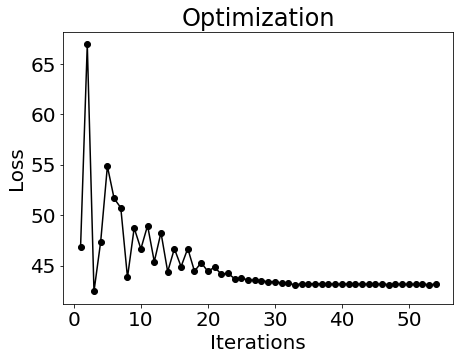


Train set:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  0.96
                 MCC:  0.86
              precision    recall  f1-score   support

          -1       0.94      0.92      0.93        50
           1       0.92      0.94      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Confusion matrix:
[[46  4]
 [ 3 47]]

Test set:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.87
                 MCC:  0.60
              precision    recall  f1-score   support

          -1       0.83      0.76      0.79        25
           1       0.78      0.84      0.81        25

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50

[[19  6]
 [ 4 21]]


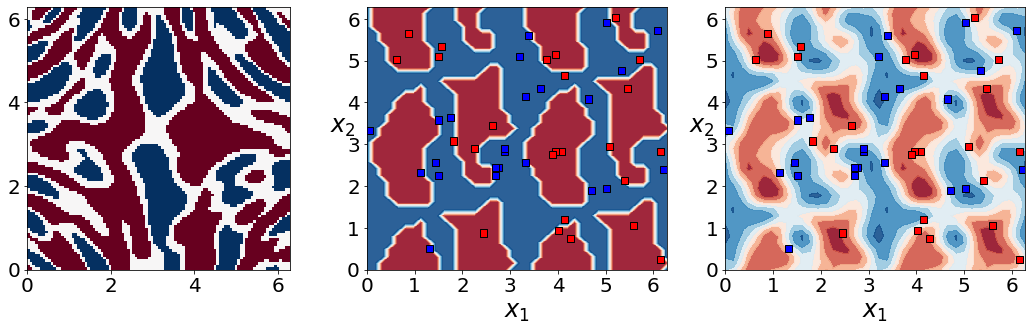

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=2

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+3*n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
p = 1
for r in range(n_layers):
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[0]*x[j%n_features], i); j += 1
    entangle(fm, 'cx', connectivity='linear') 
    for i in range(n_qubits):
        fm.u(theta[p], theta[p+1], theta[p+2], i); p += 3
    # for i in range(n_qubits):
    #     fm.crz(theta[0]*x[j%n_features], i, (i+1)%n_qubits); j += 1
    fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
# init_params = 2.0*np.ones(len(fm.train_params))
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=100,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)

     ┌───┐  ┌──────────────────────────────────┐                                     ┌───┐  ┌──────────────────────────────────┐                     »
q_0: ┤ H ├──┤ U(x[0]*θ[0],x[0]*θ[1],x[0]*θ[2]) ├───■─────────────────────────────────┤ H ├──┤ U(x[0]*θ[0],x[0]*θ[1],x[0]*θ[2]) ├───■─────────────────»
     ├───┤  ├──────────────────────────────────┤ ┌─┴─┐                               ├───┤  ├──────────────────────────────────┤ ┌─┴─┐               »
q_1: ┤ H ├──┤ U(x[1]*θ[3],x[1]*θ[4],x[1]*θ[5]) ├─┤ X ├──■────────────────────────────┤ H ├──┤ U(x[1]*θ[3],x[1]*θ[4],x[1]*θ[5]) ├─┤ X ├──■────────────»
     ├───┤  ├──────────────────────────────────┤ └───┘┌─┴─┐                          ├───┤  ├──────────────────────────────────┤ └───┘┌─┴─┐          »
q_2: ┤ H ├──┤ U(x[0]*θ[6],x[0]*θ[7],x[0]*θ[8]) ├──────┤ X ├──■───────────────────────┤ H ├──┤ U(x[0]*θ[6],x[0]*θ[7],x[0]*θ[8]) ├──────┤ X ├──■───────»
     ├───┤ ┌┴──────────────────────────────────┴┐     └───┘┌─┴─┐                     ├───┤ ┌┴─

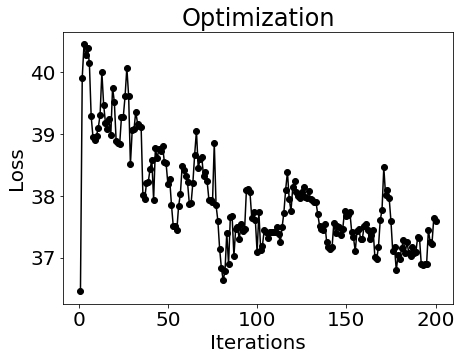


Train set:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion matrix:
[[50  0]
 [ 0 50]]

Test set:
   Balanced accuracy:  0.82
                  F1:  0.82
             ROC_AUC:  0.90
                 MCC:  0.65
              precision    recall  f1-score   support

          -1       0.77      0.92      0.84        25
           1       0.90      0.72      0.80        25

    accuracy                           0.82        50
   macro avg       0.83      0.82      0.82        50
weighted avg       0.83      0.82      0.82        50

[[23  2]
 [ 7 18]]


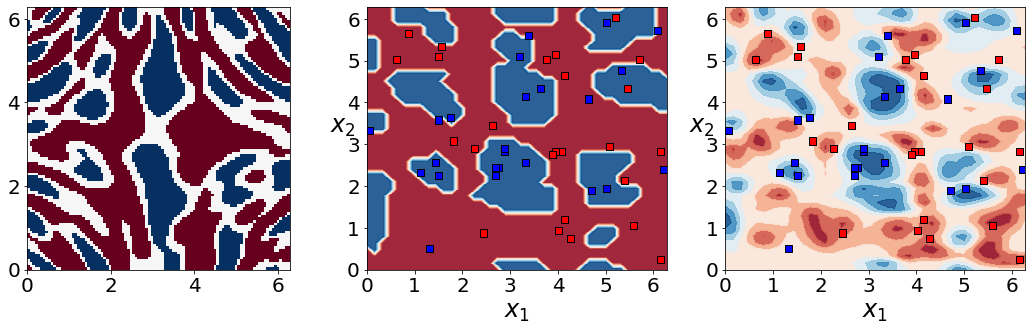

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

n_features=len(X[0])
n_qubits=8
n_layers=2

x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=3*n_qubits)
# theta = ParameterVector('θ', length=1+3*n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
    
j = 0
for r in range(n_layers):
    p = 0
    for i in range(n_qubits):
        fm.h(i)
        fm.u(theta[p]*x[j%n_features], theta[p+1]*x[j%n_features], theta[p+2]*x[j%n_features], i); j += 1; p += 3
    entangle(fm, 'cx', connectivity='linear') 
    # for i in range(n_qubits):
    #     fm.ry(theta[p], i); p += 1
    # for i in range(n_qubits):
    #     fm.crx(theta[p], i, (i+1)%n_qubits); p += 1
    # fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = 2.0*np.ones(len(fm.train_params))
# init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
# init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    maxiter=200,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

# Train set scores
scores_tr = get_scores(qsvc, X_train, y_train)
print_scores(scores_tr, title='Train set:')
y_pred = qsvc.predict(X_train)
print(classification_report(y_train, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred))

# Test set scores
scores_tt = get_scores(qsvc, X_test,  y_test)
print_scores(scores_tt, title='Test set:')
y_pred = qsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plot_results(qsvc, N=40)